# How to train a Yolov9 object detection on custom dataset
---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov9-model/)

##  Before we start !

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Dec 11 21:19:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script may contain bugs

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325 (from 1)
Receiving objects: 100% (325/325), 2.25 MiB | 5.72 MiB/s, done.
Resolving deltas: 100% (162/162), done.
/content/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.5 MB/s eta 0:00:00


## 1.&nbsp;Gather and Label Training Images

Before we start training, we need to gather and label images that will be used for training the object detection model. A good starting point for a proof-of-concept model is 200 images. The training images should have random objects in the image along with the desired objects, and should have a variety of backgrounds and lighting conditions.

**We started the training with 400 images** that we took ourselves of deodorants in _different conditions_.  
We know it's not enough for **very good learning**, but it will _do the job_!

### Manual Image Labeling with LabelImg

To train a model for detection or classification, each image needs to be labeled with the appropriate annotations (e.g., bounding boxes). In this guide, we will use **LabelImg** to annotate images manually, one by one.

#### Steps to Annotate Images with LabelImg:

1. **Install LabelImg**  
   You can download and install LabelImg from its [official GitHub page](https://github.com/heartexlabs/labelImg) or install it via pip:  
   ```bash
   pip install labelImg
   ```

2. **Launch LabelImg**  
   Once installed, you can start LabelImg by running:  
   ```bash
   labelImg
   ```

3. **Open the Folder Containing the Images**  
   In the LabelImg interface, click on **Open Dir** and select the folder where your images are located.

4. **Annotate the Images**  
   - Click on the **Create RectBox** button (or press the shortcut `w`) to draw a rectangle around the object to be labeled (e.g., a deodorant).  
   - After drawing the rectangle, type the **class name** (e.g., `deodorant`) in the pop-up window.  
   - Save the annotation by clicking on the **Save** button.

5. **Set the Annotation Format**  
   By default, LabelImg saves annotations in XML format (Pascal VOC). If your model requires YOLO format, click on **PascalVOC → YOLO** in the toolbar to switch formats.

6. **Move to the Next Image**  
   Once the annotation is saved, click on **Next Image** to proceed to the next image and repeat the process.

#### Example of Labeling with LabelImg

Below is an example showing how to annotate an object in an image using LabelImg:

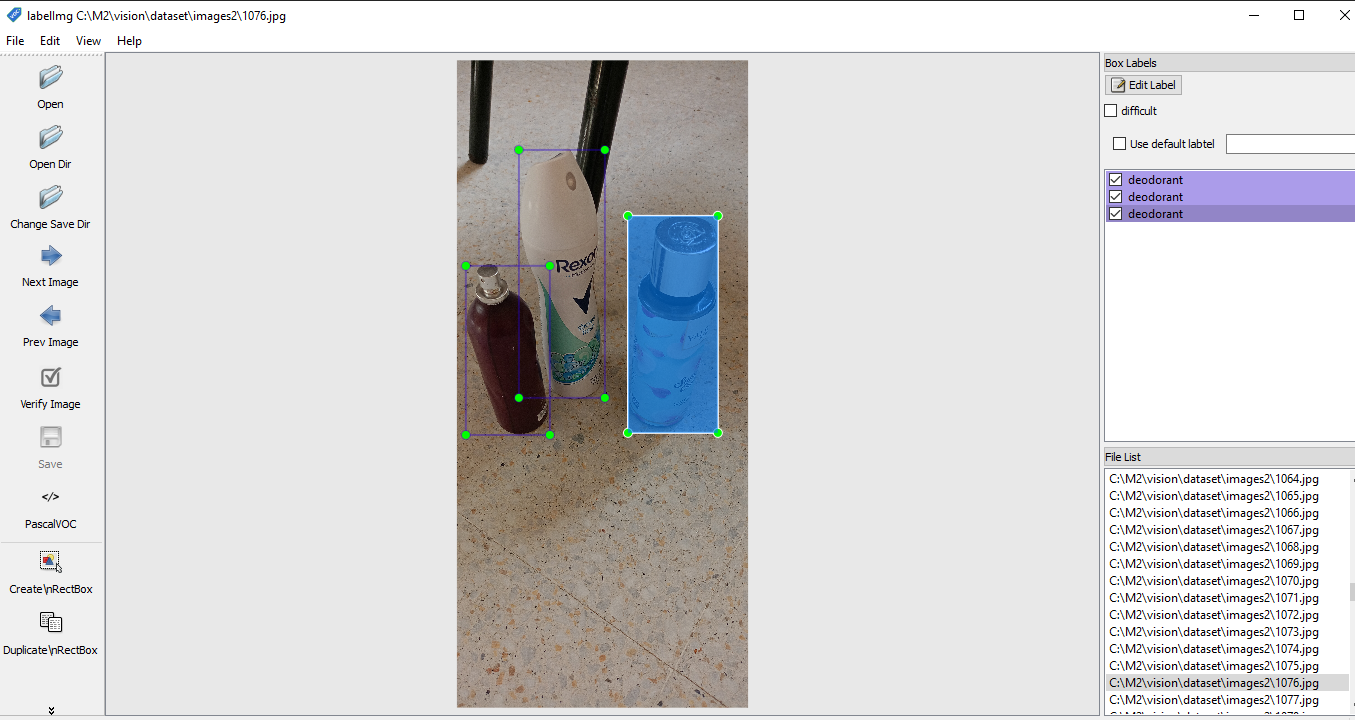

#### Tips:
- Use consistent class names for all your objects (e.g., always use `deodorant` and avoid variations like `Deo` or `Deodorant`).
- Double-check that all your images are properly labeled before starting the training process.



Inspiration Yuttube Video in the link below :
<p align=center>
<a href="https://www.youtube.com/watch?v=v0ssiOY6cfg" target="_blank"><img src="https://s3.us-west-1.amazonaws.com/evanjuras.com/img/thumbnail-capture-label-data.png" height="240"><br>
<i>Watch this video to learn how to capture and label images.</i></a>
</p>

When you've finished gathering and labeling images, you should have a folder full of images and corresponding .txt data annotation file for each image. An example of a labeled image and the image folder for my deodorant detector model are shown below.


### Example of Labeled Image
[Click here to view the image](https://app.roboflow.com/computer-vision-muvdl/deodorant-detection/1/images/5f5bc44b393bb34f95d29a827a30d890?split=train)



Note: After labeling the images, **I uploaded them to Roboflow** to make them easily usable with Colab and accessible to everyone!

**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [4]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00


## 2. Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [5]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [6]:
!ls -la {HOME}/weights

total 402444
drwxr-xr-x 2 root root      4096 Dec 11 21:21 .
drwxr-xr-x 1 root root      4096 Dec 11 21:20 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt


## Download example data

In [16]:
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/1251.jpg

In [17]:
SOURCE_IMAGE_PATH = f"{HOME}/1251.jpg"

## Detection with pre-trained COCO model

To compare it with ours after training

### gelan-c

In [18]:
!python detect.py --weights {HOME}/weights/gelan-c.pt --conf 0.1 --source {HOME}/data/1251.jpg --device 0

detect: weights=['/content/weights/gelan-c.pt'], source=/content/data/1251.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only`

**NOTE:** By default, the results of each subsequent inference sessions are saved in `{HOME}/yolov9/runs/detect/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

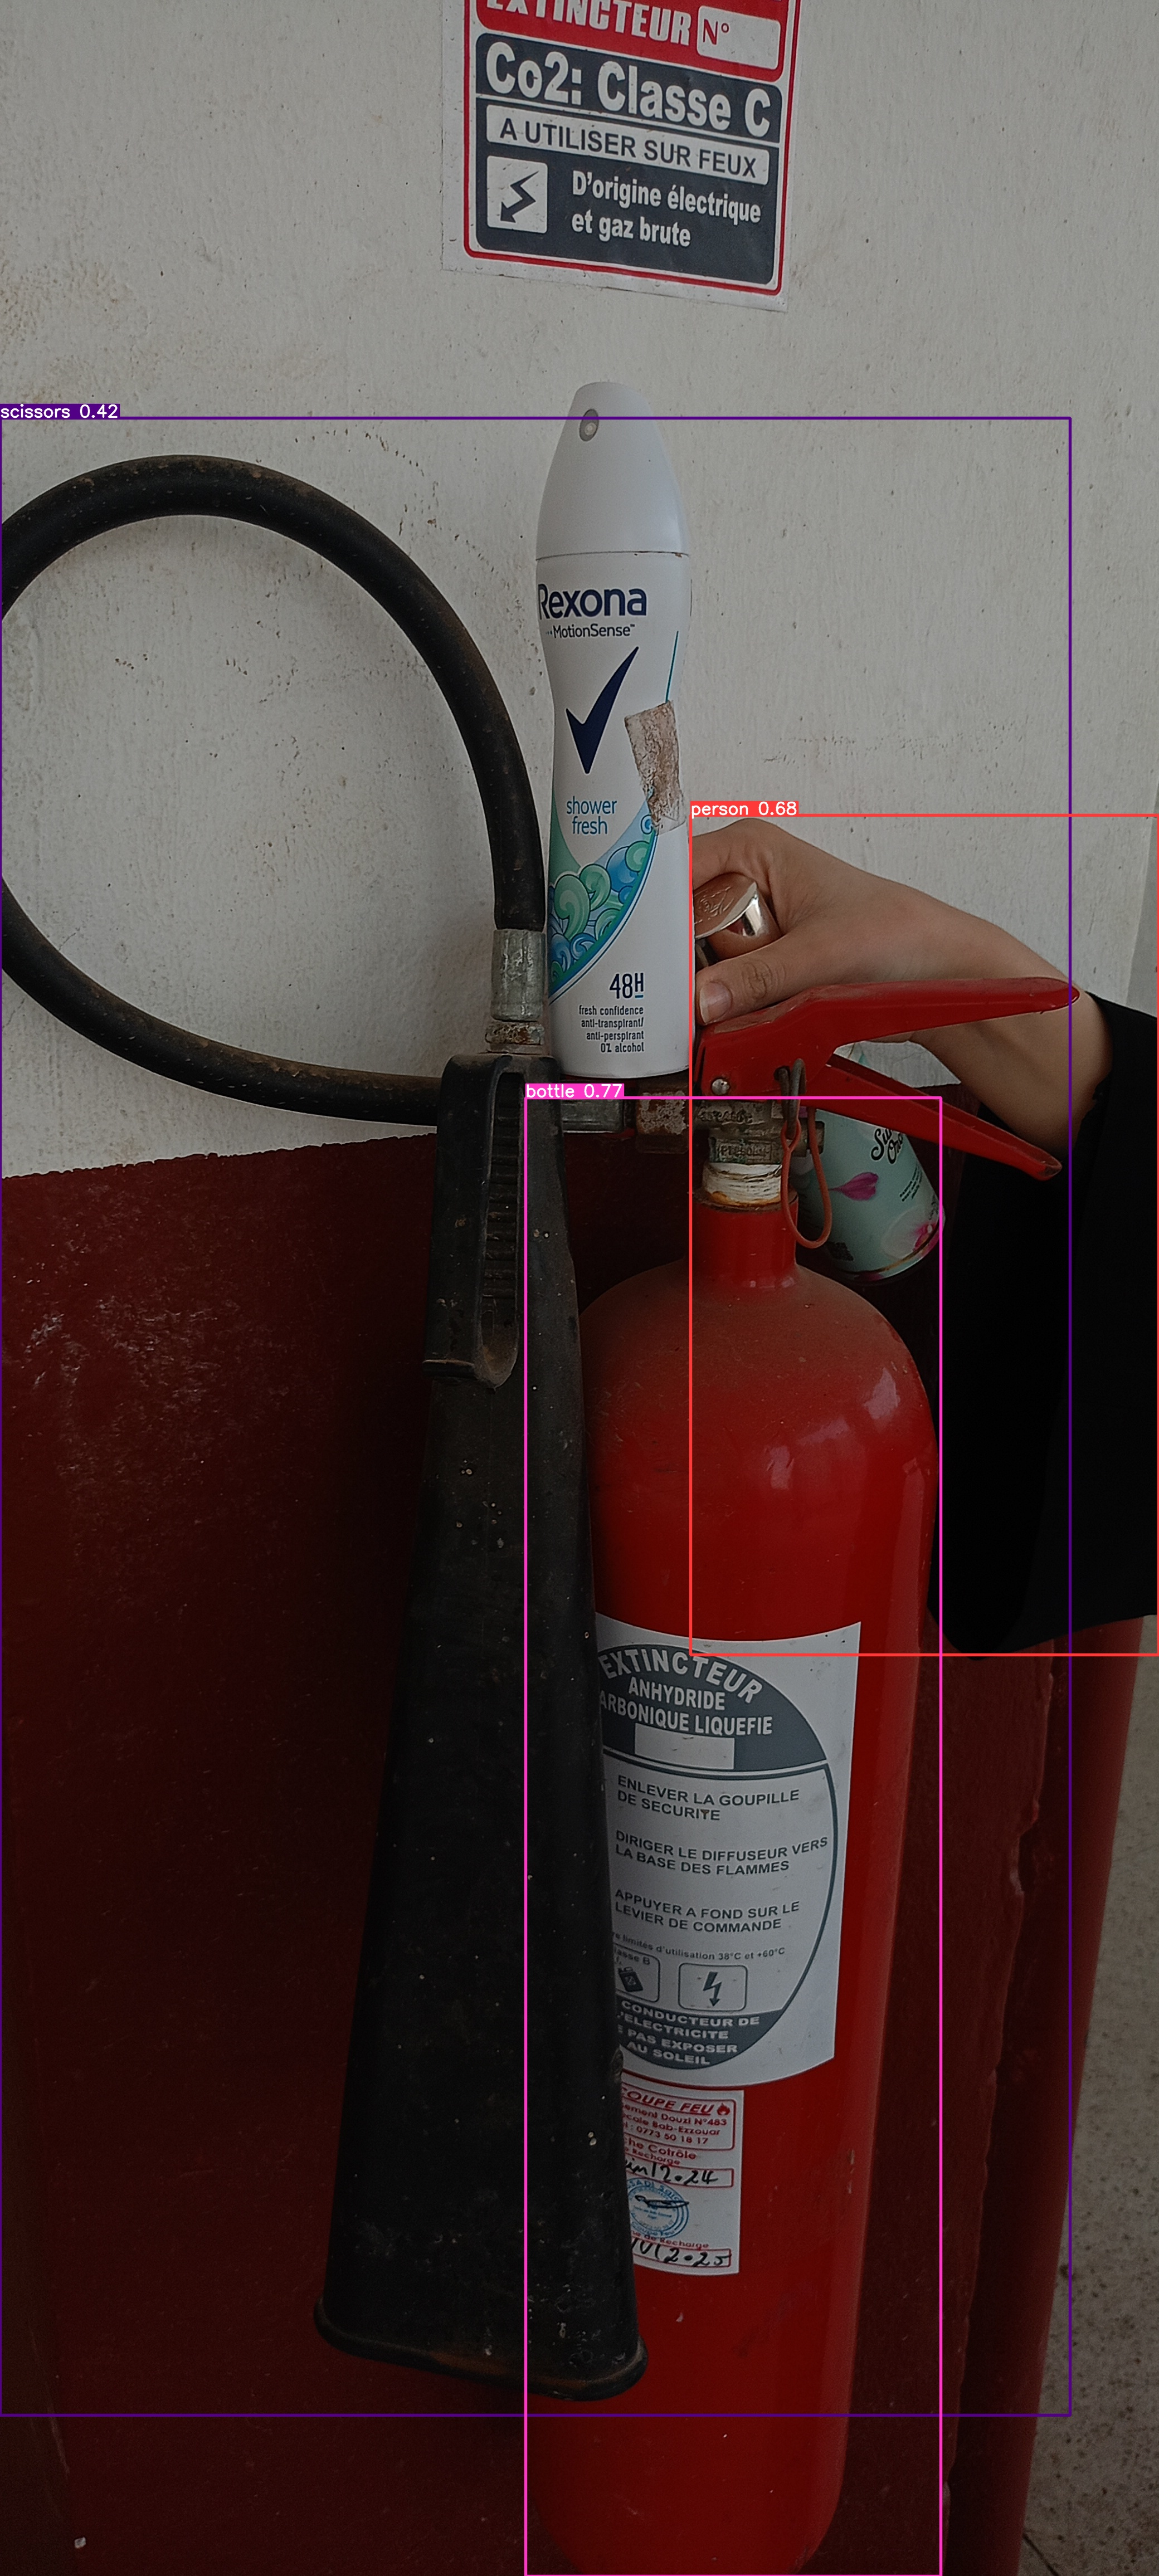

In [19]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp4/1251.jpg", width=600)

We can see that it didn't detect the small bottles (deodorants)

## yolov9-e

In [20]:
!python detect.py --weights {HOME}/weights/yolov9-e.pt --conf 0.1 --source {HOME}/data/1251.jpg --device 0

detect: weights=['/content/weights/yolov9-e.pt'], source=/content/data/1251.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only

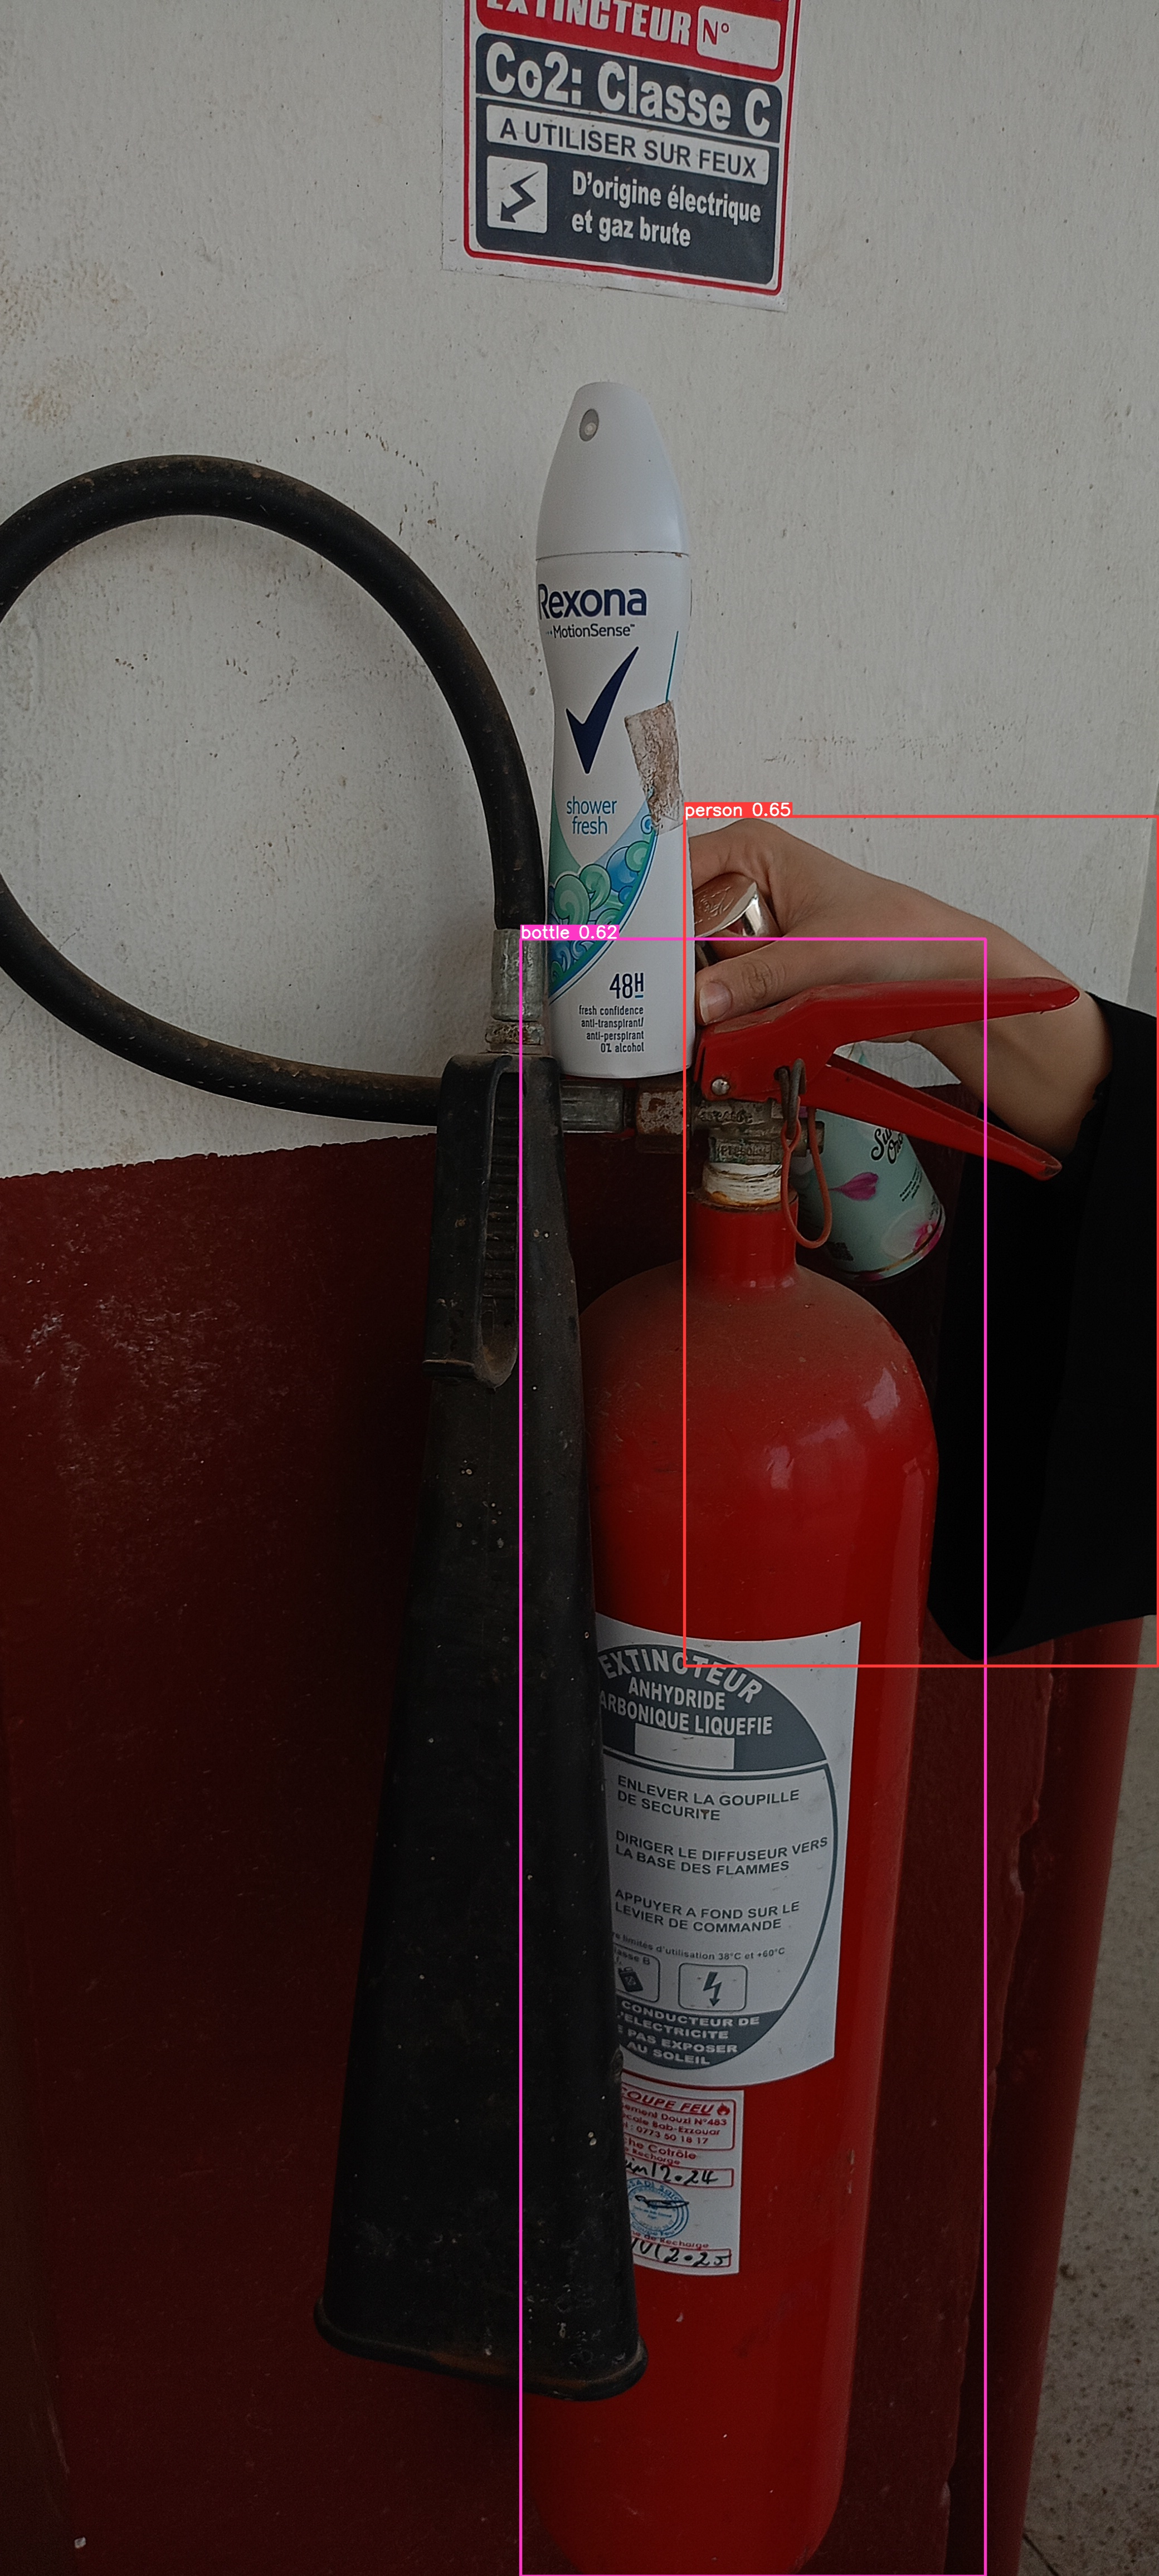

In [22]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp5/1251.jpg", width=600)

also yolov9-e didn't detect the small bottles

## 3.  Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [23]:
%cd {HOME}/yolov9

/content/yolov9


**NOTE:** In this tutorial, I will then use my dataset [deodorant-detection](https://universe.roboflow.com/computer-vision-muvdl/deodorant-detection/dataset/2) dataset. Feel free to replace it with your dataset in YOLO format or use another dataset available on [Roboflow Universe](https://universe.roboflow.com). Additionally, if you plan to deploy your model to Roboflow after training, make sure you are the owner of the dataset and that no model is associated with the version of the dataset you are going to training on!

In [24]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="pzGMURcCi6aatUmilUbK")
project = rf.workspace("computer-vision-muvdl").project("deodorant-detection")
version = project.version(2)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to deodorant-detection-2 in yolov9:: 100%|██████████| 1960/1960 [00:00<00:00, 3989.33it/s]


## 4. Train Custom Model

In [29]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 30 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-12-11 22:16:09.608195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 22:16:09.629717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 22:16:09.636264: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 22:16:09.651463: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 22:16:11.003041: W tensorf

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [30]:
!ls {HOME}/yolov9/runs/train/exp/

events.out.tfevents.1733953480.6d90fdeb956c.6831.0  hyp.yaml  opt.yaml	weights


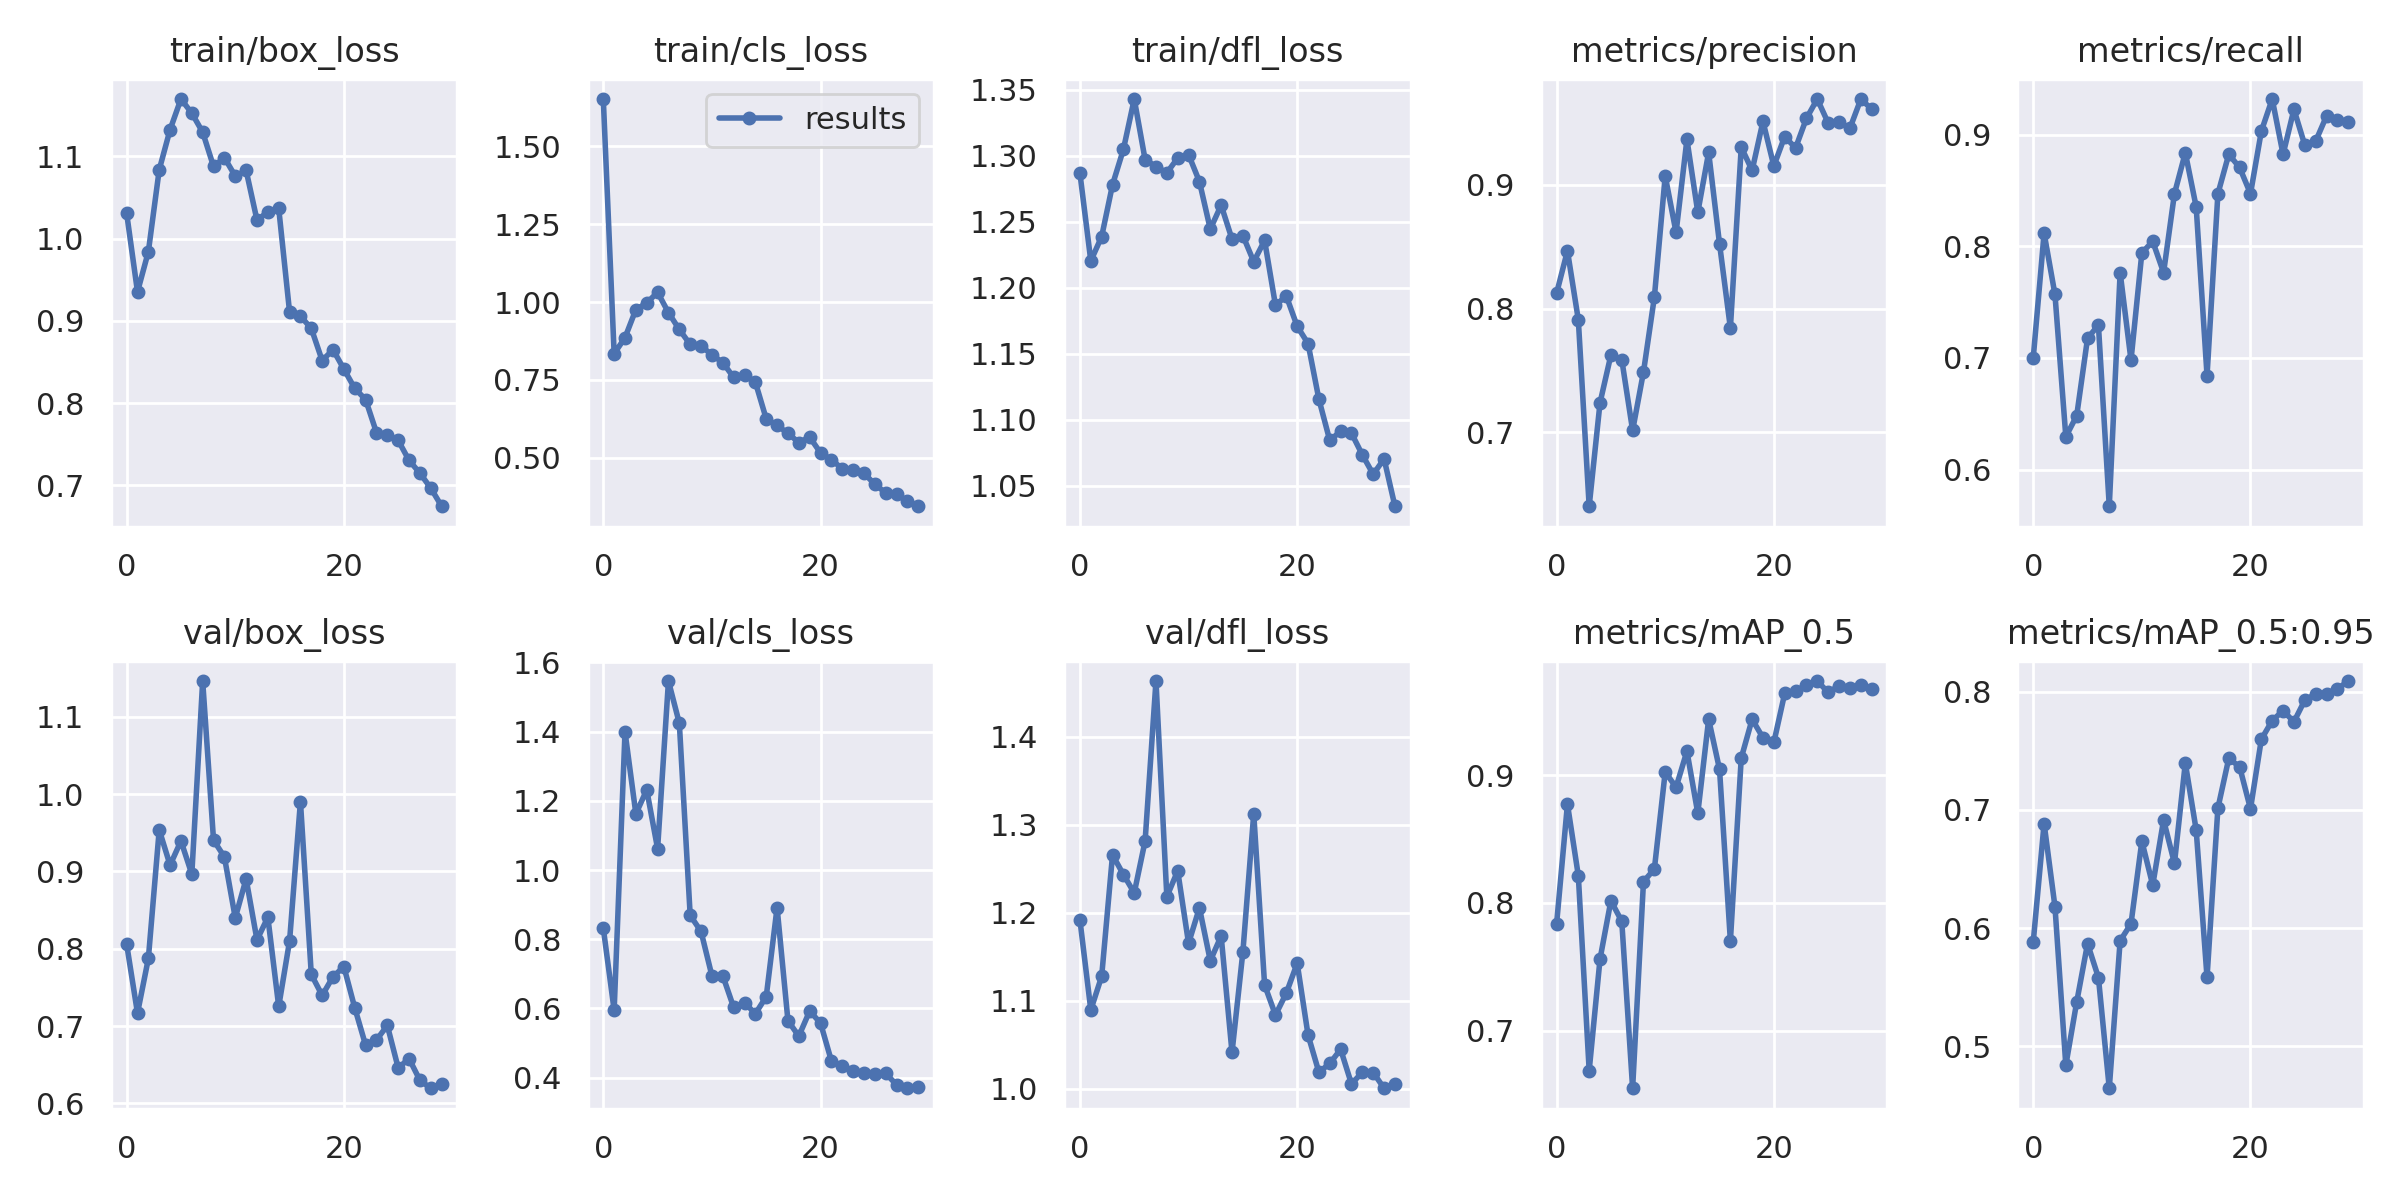

In [31]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp3/results.png", width=1000)

## 5. Validate Custom Model

In [34]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp3/weights/best.pt

/content/yolov9
val: data=/content/yolov9/deodorant-detection-2/data.yaml, weights=['/content/yolov9/runs/train/exp3/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits 

## Inference with Custom Model

In [36]:
!python detect.py \
--img 1280 --conf 0.5 --device 0 \
--weights {HOME}/yolov9/runs/train/exp3/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/content/yolov9/runs/train/exp3/weights/best.pt'], source=/content/yolov9/deodorant-detection-2/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a fut

**NOTE:** Just like behore, the inference results have been saved in the appropriate directory inside `{HOME}/yolov9/runs/detect/`. Let's examine few of those results.

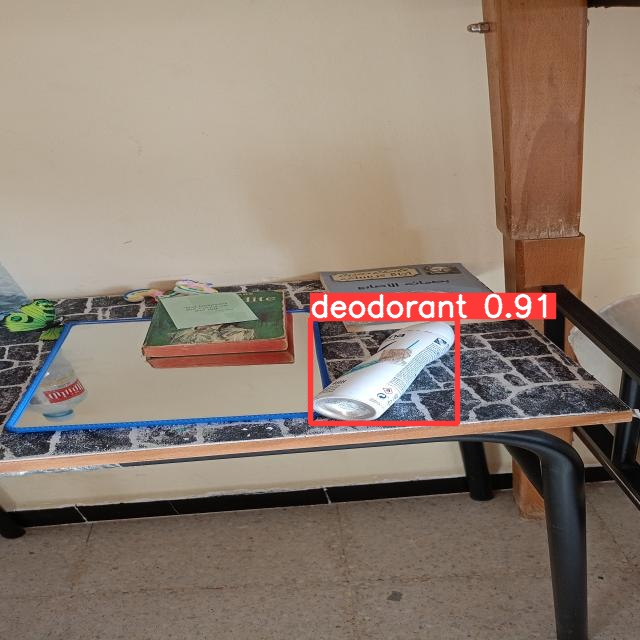

In [41]:
from IPython.display import Image

Image(filename=f"/content/yolov9/runs/detect/exp7/0894_jpg.rf.4d7b63b4403e05a79326ad8cbb17090e.jpg", width=1000)

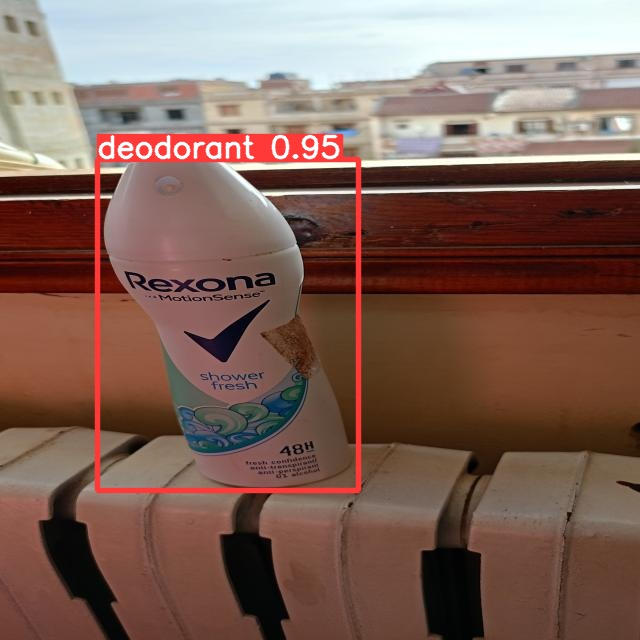

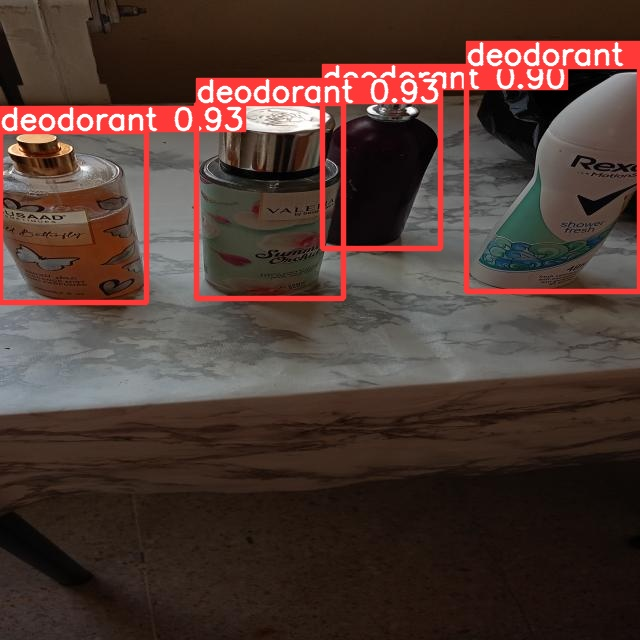

In [43]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp7/*.jpg')[-2:]:
      display(Image(filename=image_path, width=600))

## BONUS: Deploy YOLOv9 Model with Inference

**NOTE:** To deploy the model and display inference results, we will need two additional packages - [`inference`](https://pypi.org/project/inference) and [`supervision`](https://pypi.org/project/supervision). Let's install and import them!

In [44]:
!pip install -q inference supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.0/881.0 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.5 MB/s

In [45]:
import cv2
import random
import getpass

import supervision as sv

from inference import get_model

%matplotlib inline

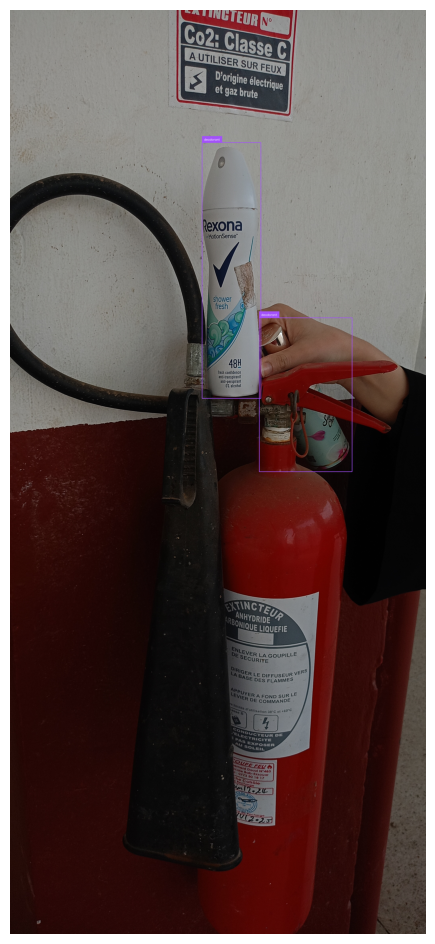

In [47]:
# define the image url to use for inference
image_file = "/content/data/1251.jpg"
image = cv2.imread(image_file)

# load a pre-trained yolov8n model
model = get_model(model_id="deodorant-detection/2", api_key="pzGMURcCi6aatUmilUbK")

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
results = model.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

We can see that our trained Yolov9 model in now capable to detect objects in the image. The model is able to detect the deodorant bottles with high accuracy and precision.

## Precision with the first version (No augmentation steps on data)

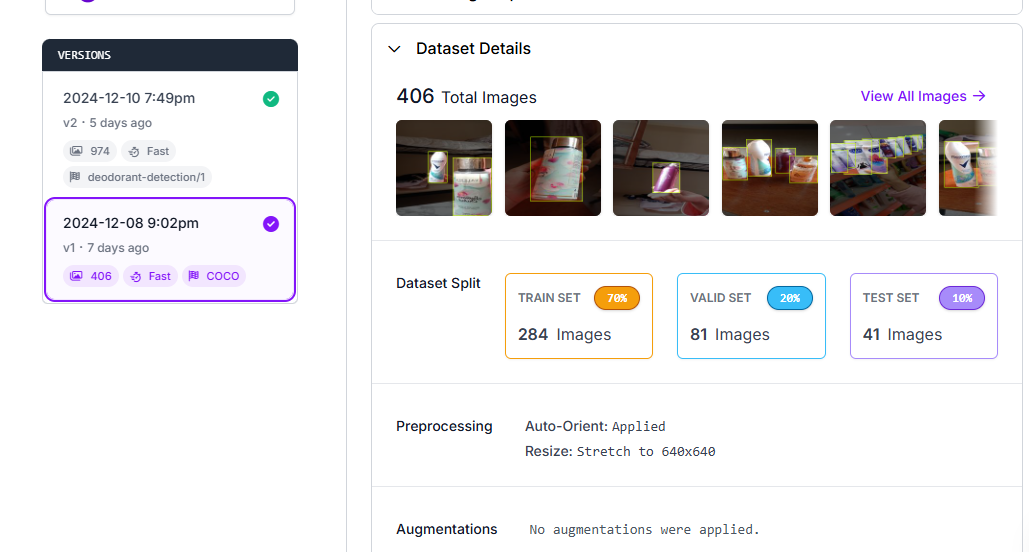

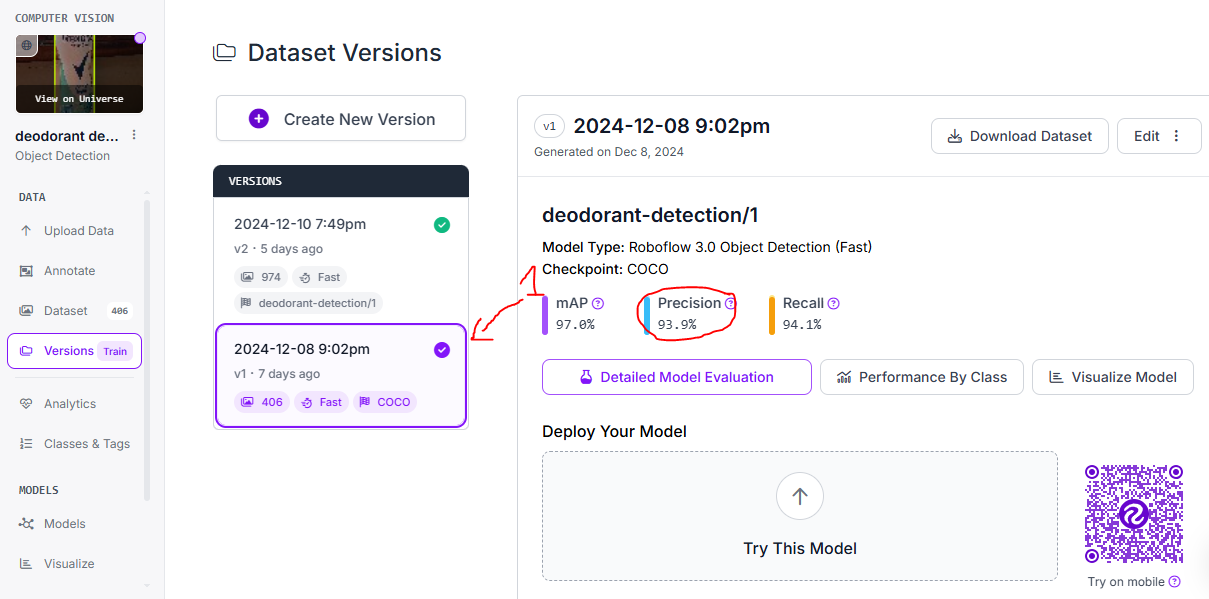

## Precision with the second version

Training With augmentation data steps 
1. Flip: Horizontal, Vertical
2. 90° Rotate: Clockwise, Counter-Clockwise
3. Shear: ±10° Horizontal, ±10° Vertical
4. Grayscale: Apply to 15% of images
5. Brightness: Between -22% and +22%
6. Blur: Up to 2.5px
7. Noise: Up to 0.93% of pixels

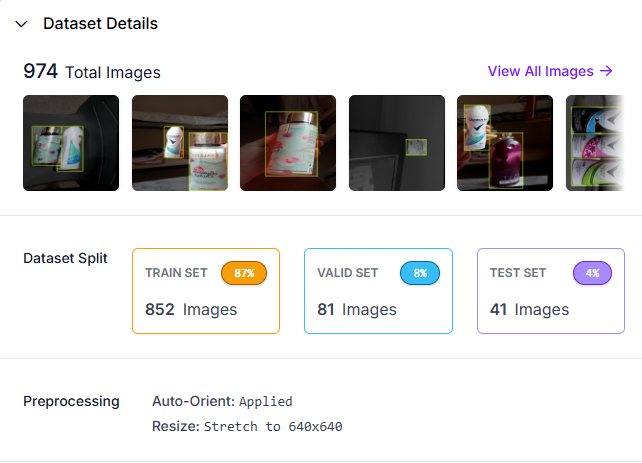

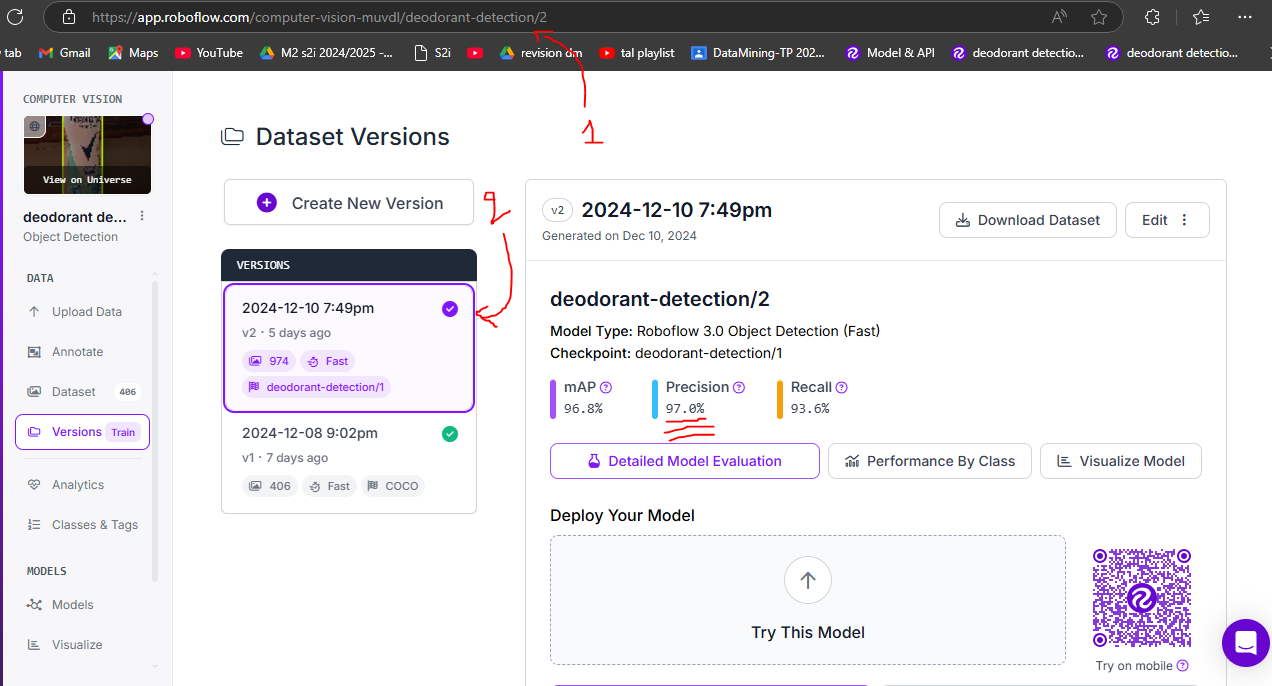

## Downloading the results to use them localy

In [48]:
!zip -r /content/yolov9_and_weights.zip /content/yolov9 /content/weights
from google.colab import files
files.download('/content/yolov9_and_weights.zip')

  adding: content/yolov9/ (stored 0%)
  adding: content/yolov9/deodorant-detection-2/ (stored 0%)
  adding: content/yolov9/deodorant-detection-2/train/ (stored 0%)
  adding: content/yolov9/deodorant-detection-2/train/labels.cache (deflated 66%)
  adding: content/yolov9/deodorant-detection-2/train/images/ (stored 0%)
  adding: content/yolov9/deodorant-detection-2/train/images/1097_jpg.rf.8688571a0af3545f1cf7a5b998279ca9.jpg (deflated 5%)
  adding: content/yolov9/deodorant-detection-2/train/images/1039_jpg.rf.24e9ead10abcb3f9772cf41353239128.jpg (deflated 1%)
  adding: content/yolov9/deodorant-detection-2/train/images/1267_jpg.rf.f14e530846ba54567fb182350932427f.jpg (deflated 2%)
  adding: content/yolov9/deodorant-detection-2/train/images/0958_jpg.rf.16f5e0af4bd4f15aec48b1d090046a55.jpg (deflated 1%)
  adding: content/yolov9/deodorant-detection-2/train/images/1265_jpg.rf.828cecba9800e39aa6c4e8dea37ba602.jpg (deflated 1%)
  adding: content/yolov9/deodorant-detection-2/train/images/0869_jp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
from google.colab import files
files.download('/content/yolov9_and_weights.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>